**Table of contents**<a id='toc0_'></a>    
- [Notes / Summary](#toc1_)    
- [Required Libraries](#toc2_)    
- [Linear Regression](#toc3_)    
  - [the normal equation](#toc3_1_)    
  - [SVD - singular value decomposition & pseudoinverse](#toc3_2_)    
  - [Computational complexity](#toc3_3_)    
- [Gradient Descent](#toc4_)    
  - [Batch Gradient Descent](#toc4_1_)    
  - [Stochastic Gradient Descent (SGD)](#toc4_2_)    
    - [learning schedule](#toc4_2_1_)    
  - [Mini batch Gradient Descent](#toc4_3_)    
- [Polynomial Regression](#toc5_)    
- [Learning Curves](#toc6_)    
- [Bias, Variance, Irreducible error](#toc7_)    
- [Regularized Linear Models](#toc8_)    
- [Ridge Regression](#toc9_)    
- [Lasso Regression](#toc10_)    
- [Early Stopping](#toc11_)    
- [Logistic Regression](#toc12_)    
  - [Decision Boundaries](#toc12_1_)    
- [Softmax Regression](#toc13_)    
- [Exercises](#toc14_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Notes / Summary](#toc0_)

1. Having a good understanding of how things work can help you quickly home in on the appropriate model \
the right algorithm to use, and a agood set of hyperparameters for your task.
2. understanding what's under the hood will also help you debug issues and perform error analysis more efficiently.
3. lastly most of the topics discussed in this chapter will be essential in understanding, building and training NN


* On top of linear regression, we have polynomial regression, a more complex model that can fit nonline datasets.
* since this model has more parameters than linear regression, it is more prone to overfitting the training data.
* to check whether or not this is the case by using learning curves, and then we can use regularization to prevent overifiting


* learning algorithms will often optimize a different loss function during training than the performance measure used
* to evaluate the final model. this is generally because the function is easier to optimize and/or because 
* it has extra terms needed during training only e.g. for regularization
* A good performance metric is as close as possible to the final business objective.
* A good training loss is easy to optimize and strongly correlated with the metric
* For example, classifiers are often trained using a cost fucntion such as the log loss, but 
* evaluated using precision/recall. 
* The log lossis easy to minimize, and doing so weill usually improve precision / recall

# <a id='toc2_'></a>[Required Libraries](#toc0_)

In [33]:
import  numpy as np 

In [ ]:
RS = 143 # random state

# <a id='toc3_'></a>[Linear Regression](#toc0_)

Equation :    
![image.png](attachment:image.png)

Vectorized equation:\
![image-2.png](attachment:image-2.png)

* to train a linear regression model, we need to find the value of theta that minimizes the RMSE
* in practise it is simpler to minimize the mean squared error (MSE) than the RMSE and it leads to the same result
* (becasue the value that minimizes a positive function also minimizes its square root)\
\
Normal equation: to find the value of theta that minimizes the MSE there exisats a closed form solution, math eqn.\
![image-3.png](attachment:image-3.png)



## <a id='toc3_1_'></a>[the normal equation](#toc0_)

In [35]:
np.random.seed(143) # to make this code example reproducible
num = 100 # number of instances
x = 2 * np.random.rand(num, 1) # column vector 
y = 4 + 3 * x + np.random.randn(num, 1 ) # column vector


In [36]:
## now lets compute theta using normal equation

from sklearn.preprocessing import  add_dummy_feature 
x_b = add_dummy_feature(x)
theta = np.matmul(np.matmul(np.linalg.inv(np.matmul(x_b.T, x_b)), x_b.T), y)
# theta = np.linalg.inv(x_b.T @ x_b) @ x_b.T @ y ## above and this line both are the same in diff. reprsentations
theta

array([[3.98476171],
       [3.09535726]])

* the function we used to generate the data is y = 4 + 3x1 + gaussian noise

* theta generated is ; theta0 is 3.98, theta1 is 3.09, close to the acutal values of 4 and 3 
* it will never be same due to the gaussian noise, this made impossible to recover the exact parameters of the original function
* the smaller and noisier the dataset, the harder it gets

In [37]:
## now using the theta from above, lets predict some values

x_new = np.array([[0], [2]])
x_newb = add_dummy_feature(x_new)
y_predict = x_newb @ theta
y_predict

array([[ 3.98476171],
       [10.17547623]])

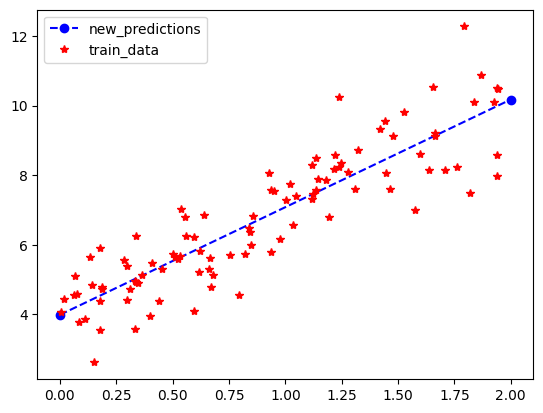

In [38]:
# lets plot the above 

import matplotlib.pyplot as plt

plt.plot(x_new, y_predict, 'ob--', label='new_predictions')
plt.plot(x, y, 'r*', label='train_data')
plt.legend()
plt.show()

Performing linear regression using scikit

In [39]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.98476171]), array([[3.09535726]]))

In [ ]:
lin_reg.predict(x_new)

array([[ 3.98476171],
       [10.17547623]])

## <a id='toc3_2_'></a>[SVD - singular value decomposition & pseudoinverse](#toc0_)
* the above linear regression class from scikit learn uses pseudoinversel due to less time complexity
* the pseudoinverse itself is computed using a standard matrix factorization technique called singular value decomposition - SVD

## <a id='toc3_3_'></a>[Computational complexity](#toc0_)
* the normal equation , if you double the number of features, you multiply \
the computation **time by 8 times**
* using SVD / pseudoinverse method it will be **4 times**

# <a id='toc4_'></a>[Gradient Descent](#toc0_)
* Due to above time complexities, we try different methods to train a linear regression model
* This is better suited for cases where there are a larger number of featrues or too many data points
* Gradient Descent is an optimization algorithm used to minimize the cost function
* **what gradient descent does: it measures the local gradient of the error fucniton wrto parameter theta.**

* In practice, you start by filling θ with random values (this is called random initiali‐\
zation). Then you improve it gradually, taking one baby step at a time, each step\
attempting to decrease the cost function (e.g., the MSE), until the algorithm converges
to a minimum


* In gradient descent, the size of steps is the learning reat hyperparameter
* to small step and it will take a long time to converge
* to large step and it will overshoot the curves and sometimes it may never reach global minumum
* **two main challenges in gradient descent is 1.local minimum 2. Plateau**


* Fortunately, the MSE cost function for a linear regression model happens to be a\
convex function, which means that if you pick any two points on the curve, the line\
segment joining them is never below the curve. This implies that there are no local\
minima, just one global minimum. It is also a continuous function with a slope that\
never changes abruptly.2 These two facts have a great consequence: gradient descent\
is guaranteed to approach arbitrarily closely the global minimum (if you wait long\
enough and if the learning rate is not too high)\


* the cost function has the shape of a bowl, it can be an elongated bowl if the features have very different scales.

![image.png](attachment:image.png)
* left we can see gradient descent algorithm directly goes towards the minimum
* right side , it first goes in orthogonal direction to the global minimum and then changes towards the minimum.
* **when using gradient descent you should ensure that all features have a similar scale**

! **training a model means searching for a combination of model parameters that minimizes the cost function.**

## <a id='toc4_1_'></a>[Batch Gradient Descent](#toc0_)
* To implement gradient descent, you need to compute the gradient of the cost func‐\
tion with regard to each model parameter θj. In other words, you need to calculate\
how much the cost function will change if you change θj just a little bit. This is called\
a partial derivative. It is like asking, “What is the slope of the mountain under my\
feet if I face east”? and then asking the same question facing north \

![image.png](attachment:image.png)
* Notice that this formula involves calculations over the full training\
set X, at each gradient descent step! This is why the algorithm is\
called batch gradient descent: it uses the whole batch of training\
data at every step   
* As a result, it is terribly slow on very large
training sets. 
* However, gradient descent scales well with the\
number of features; training a linear regression model when there\
are hundreds of thousands of features is much faster using gradient\
descent than using the Normal equation or SVD decomposition.

![image-2.png](attachment:image-2.png)


In [41]:
# BGD implementation

eta = 0.1 # learningrate
n_epocsh = 1000 # number of epochs; 
m = len(x_b)

np.random.seed(143)
theta = np.random.randn(2,1)

for epoch in range(n_epocsh):
    gradients = 2 / m * x_b.T @ ( x_b @ theta -y )
    theta = theta -eta* gradients # next step theta
theta

## the result almost similar to the normal equation and SVD implementation

array([[3.98476171],
       [3.09535726]])

* To find a good learning rate, you can use grid search, However, you \
may want to limit the number of epochs so that grid search can eliminate models that
take too long to converge.\

* how to set the number of epochs. If it is too low, you will still be\
far away from the optimal solution when the algorithm stops; but if it is too high,\
you will waste time while the model parameters do not change anymore. 
* A simple solution is to set a very large number of epochs but to interrupt the algorithm when\
the gradient vector becomes tiny—that is, when its norm becomes smaller than a\
**tiny number ϵ (called the tolerance)**—because this happens when gradient descent has
(almost) reached the minimum.

## <a id='toc4_2_'></a>[Stochastic Gradient Descent (SGD)](#toc0_)

* stochastic gradient descent picks a\
random instance in the training set at every step and computes the gradients based\
only on that single instance. 
* Obviously, working on a single instance at a time makes\
the algorithm much faster because it has very little data to manipulate at every
iteration. 
* It also makes it possible to train on huge training sets, since only one
instance needs to be in memory at each iteration
* **the final parameter values will be good, but not optimal.**

* With stochastic gradient descent, each training step is much faster but also
much more stochastic than when using batch gradient descent
* when cost function is very irregular, then SGD has a better chance of finding the global minimum than batch gradient descent
* randomness is good to escape local minimum, but it will never settle at the global minimum
* here we can gradually reduce the learning rate.
* the steps start out large then get smaller and smaller alloweing the algorithm to settle at the global minimum
* **this is called simulated annealing, the function that determines the learning rate at each iteration is learning schedule.**

### <a id='toc4_2_1_'></a>[learning schedule](#toc0_)

In [42]:
n_epochs = 50
t0, t1 = 5,50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0/(t + t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for iteration in range(m):
        random_index = np.random.randint(m)
        xi = x_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        # gradient descent
        gradients = 2 * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch *m + iteration)
        theta = theta - eta * gradients
        


* Note that since instances are picked randomly, some instances may be picked several\
times per epoch, while others may not be picked at all


* If you do not shuffle
the instances—for example, if the instances are sorted by label—\
then SGD will start by optimizing for one label, then the next, and\
so on, and it will not settle close to the global minimum.

In [ ]:
# SGD regression from scikit
from sklearn.linear_model import SGDRegressor

sgd_regr = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01, 
                        n_iter_no_change=100, random_state=RS)
sgd_regr.fit(x, y.ravel())
sgd_regr.intercept_, sgd_regr.coef_

(array([3.98551609]), array([3.09605942]))

## <a id='toc4_3_'></a>[Mini batch Gradient Descent](#toc0_)
* mini-batch GD com‐putes the gradients on small random sets of instances called mini-batches. 
* The main advantage of mini-batch GD over stochastic GD is that you can get a performance\
boost from hardware optimization of matrix operations, especially when using GPUs.
* mini-batch GD will end up walking around a bit closer to the minimum 
* than stochastic GD—but it may be harder for it to escape from local minima

![image.png](attachment:image.png)

# <a id='toc5_'></a>[Polynomial Regression](#toc0_)
* Using a linear model to fit nonlinear data. A simple way to do this is to add powers of each\
feature as new features, then train a linear model on this extended set of features. This\
technique is called polynomial regression.

* use Scikit-Learn’s PolynomialFeatures class to transform our training data, adding the square (second- \
degree polynomial) of each feature in the training set as a new feature 

In [44]:
m = 100
x = 6 * np.random.rand(m,1) - 3
y = 0.5 * x ** 2 + x + 2 + np.random.randn(m,1)

from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)

xpoly = poly_features.fit_transform(x)

In [45]:
lin_reg = LinearRegression()
lin_reg.fit(xpoly, y)
lin_reg.intercept_, lin_reg.coef_


(array([1.61740614]), array([[1.02288352, 0.5717096 ]]))

Beware of the
combinatorial explosion of the number of features!

# <a id='toc6_'></a>[Learning Curves](#toc0_)
* This high-degree polynomial regression model is severely overfitting the training\
data, while the linear model is underfitting it. The model that will generalize best in\
this case is the quadratic model, which makes sense because the data was generated\
using a quadratic model. 

* **If a model performs well on the training data but generalizes poorly\
according to the cross-validation metrics, then your model is overfitting. If it per‐\
forms poorly on both, then it is underfitting.**

* Another way to tell is to look at the learning curves, which are plots of the model’s\
training error and validation error as a function of the training iteration: just evaluate\
the model at regular intervals during training on both the training set and the\
validation set, and plot the results.

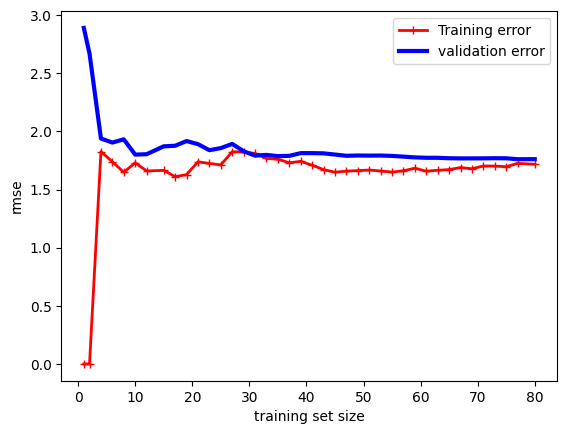

In [46]:
from sklearn.model_selection import learning_curve

trainsizes, trainscores, validscoers = learning_curve(
    LinearRegression(), x, y, train_sizes=np.linspace(0.01,1.0,40), cv=5, n_jobs=-1, 
    scoring='neg_root_mean_squared_error')
trainerrors = -trainscores.mean(axis=1)
validerrrors = -validscoers.mean(axis=1)

plt.plot(trainsizes, trainerrors, 'r-+', linewidth=2, label='Training error')
plt.plot(trainsizes, validerrrors,'b-', linewidth=3, label='validation error')
plt.legend()
plt.ylabel('rmse')
plt.xlabel('training set size')
plt.show()

* the above model is underfitting.

* **If your model is underfitting the training data, adding more train‐\
ing examples will not help. You need to use a better model or come up with better features.**



In [47]:
from sklearn.pipeline import make_pipeline

polyreg = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression()
)

polyreg

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=10, include_bias=False)),
                ('linearregression', LinearRegression())])

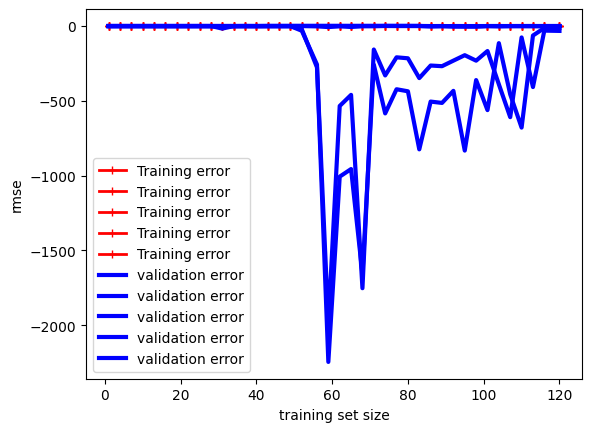

In [67]:
trainsizes, trainscores, validscores = learning_curve(
    polyreg, x,y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5, 
    scoring='neg_root_mean_squared_error'
)

plt.plot(trainsizes, trainscores, 'r-+', linewidth=2, label='Training error')
plt.plot(trainsizes, validscores,'b-', linewidth=3, label='validation error')

plt.legend()
plt.ylabel('rmse')
plt.xlabel('training set size')
plt.show()



* **One way to improve an overfitting model is to feed it more training
data until the validation error reaches the training error.**


# <a id='toc7_'></a>[Bias, Variance, Irreducible error](#toc0_)

* A high bias model is most likely to underfit the training data
* A model with many degrees of freedom is likely to have high variance and thus overfith the training data
* Irreducible error: is due to the noisiness of the data itself.
  * The only way to reduce this part of the error is clean up the data.

![image.png](attachment:image.png)

# <a id='toc8_'></a>[Regularized Linear Models](#toc0_)

* a good way to reduce overfitting is to regularize the model  the fewer degrees of freedom it has,\
the harder it will be for it to overfit the data. A simple way to regularize a polynomial model is to reduce\
the number of polynomial degrees.

# <a id='toc9_'></a>[Ridge Regression](#toc0_)
* A regularization term is added to the MSE
* This forces the learning algorithm to not only fit the data but also keep the model weights\
as small as possible. 
* The hyperparameter α controls how much you want to regularize the model. 
* If α = 0, then ridge regression is just linear regression. If α is very large, then all weights\
end up very close to zero and the result is a flat line going through the data’s mean.

![image.png](attachment:image.png)

* **t is important to scale the data (e.g., using a StandardScaler)\
before performing ridge regression, as it is sensitive to the scale of\
the input features. This is true of most regularized models.**

In [52]:
# ridge regression

from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.1, solver='cholesky')
ridgereg.fit(x,y)
ridgereg.predict([[1.5]])

array([5.08852693])

In [53]:
# using stochastic gradient descent as ridge regression

sgd_reg = SGDRegressor(penalty='l2',alpha=0.1/m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_reg.fit(x, y.ravel()) # y.ravel() becasue fit() expects 1D targets
sgd_reg.predict([[1.5]])

array([5.09289414])

* The RidgeCV class also performs ridge regression, but it automatically tunes 
hyperparameters using cross-validation. 
* It’s roughly equivalent to using GridSearchCV, but it’s optimized for ridge\
regression and runs much faster. Several other estimators (mostly\
linear) also have efficient CV variants, such as LassoCV and
ElasticNetCV.

# <a id='toc10_'></a>[Lasso Regression](#toc0_)
* just like ridge regression, it adds a regularization term to the cost function,\
 but it uses the ℓ1 norm of
the weight vector instead of the square of the ℓ2 norm 
* important characteristic of lasso regression is that it tends to eliminate the weights\
of the least important features (i.e., set them to zero).
* lasso regression **automatically** performs feature selection and outputs a sparse model\
with few nonzero feature weights.

In [ ]:
from sklearn.linear_model import Lasso

lassoreg = Lasso(alpha=0.1)
lassoreg.fit(x,y)
lassoreg.predict([[1.5]])

array([5.04288823])

# <a id='toc11_'></a>[Early Stopping](#toc0_)
* A very different way to regularize iterative learning algorithms such as gradient\
descent is to stop training as soon as the validation error reaches a minimum. 
* With stochastic and mini-batch gradient descent, the curves are\
not so smooth, and it may be hard to know whether you have\
reached the minimum or not. **One solution is to stop only after the\
validation error has been above the minimum for some time, then roll\
back the model parameters to the point where the validation error
was at a minimum.**

In [ ]:
# from copy import deepcopy
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split

# m = 100
# x = 6 * np.random.rand(m,1) - 3
# y = 0.5 * x ** 2 + x + 2 + np.random.randn(m,1)

# xtrain, ytrain, xvalid, yvalid = train_test_split(x,y, test_size=0.2, random_state=RS)

# preprocessing= make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
#                              StandardScaler())
# xtrainprep = preprocessing.fit_transform(xtrain)
# xvalidprep = preprocessing.transform(xvalid)

# sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=RS)
# nepochs = 500
# bestvalidrmse = float('inf')

# for epoch in range(n_epochs):
#     sgd_reg.partial_fit(xtrainprep, ytrain    )
#     yvalidpredict = sgd_reg.predict(xvalidprep)
#     valerror = mean_squared_error(yvalid, yvalidpredict, squared=False)
#     if valerror < bestvalidrmse:
#         bestvalidrmse = valerror
#         bestmodel = deepcopy(sgd_reg)

# <a id='toc12_'></a>[Logistic Regression](#toc0_)

*  Logistic regression (also called logit regression) is commonly used to\
estimate the probability that an instance belongs to a particular class

![image.png](attachment:image.png)

* The score t is often called the logit. 
* ![image-2.png](attachment:image-2.png)

## <a id='toc12_1_'></a>[Decision Boundaries](#toc0_)

In [57]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [58]:
iris.data.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [68]:
from sklearn.linear_model import LogisticRegression

x = iris.data[['petal width (cm)']].values
y = iris.target_names[iris.target]  == 'virginica'



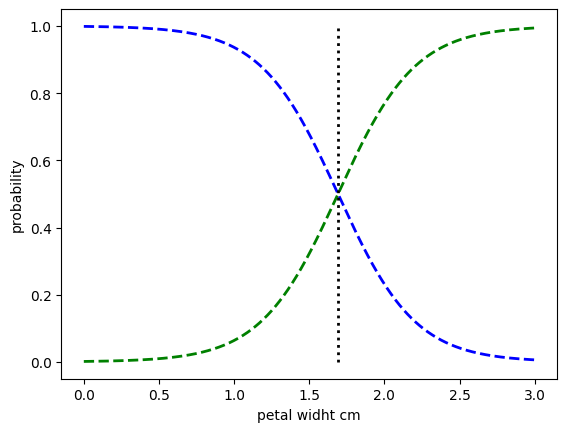

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=RS)

logreg = LogisticRegression(random_state=RS)
logreg.fit(xtrain, ytrain)


xnew = np.linspace(0,3,1000).reshape(-1,1)
yproba = logreg.predict_proba(xnew)

decision_boundary = xnew[yproba[:, 1] >= 0.5][0,0]

plt.plot(xnew, yproba[:,0], 'b--', linewidth=2,
         label='not iris virginica proba')
plt.plot(xnew, yproba[:,1], 'g--', linewidth=2, label='iris virginica proba')
plt.plot([decision_boundary, decision_boundary], [0, 1], 'k:', linewidth=2, label='Decision boundary')
plt.xlabel('petal widht cm')
plt.ylabel('probability')
plt.show()

# <a id='toc13_'></a>[Softmax Regression](#toc0_)

* logistic regression model can be generalized to support multiple classes directly,
* is called softmax regression, or multinomial logistic regression.
* The softmax regression classifier predicts only one class at a time\
**(i.e., it is multiclass, not multioutput)**, so it should be used only\
with mutually exclusive classes, such as different species of plants.\
You cannot use it to recognize multiple people in one picture.

In [ ]:
# use softmax to classify the iris plants into all three classes

x = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris['target']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=RS)

sfotmaxreg = LogisticRegression(C=30, random_state=RS)
sfotmaxreg.fit(xtrain, ytrain)

sfotmaxreg.predict([[5,2]]),sfotmaxreg.predict_proba([[5,2]]).round(4)




(array([2]), array([[0.    , 0.0475, 0.9525]]))

# <a id='toc14_'></a>[Exercises](#toc0_)
https://colab.research.google.com/github/ageron/handson-ml3/blob/main/04_training_linear_models.ipynb#scrollTo=Kqi_J4WLMQFp 

9. Suppose you are using ridge regression and you notice that the training error\
and the validation error are almost equal and fairly high. Would you say that\
the model suffers from high bias or high variance? Should you increase the
regularization hyperparameter α or reduce it?
  * If both the training error and the validation error are almost equal and fairly high,\
   the model is likely underfitting the training set, which means it has a high bias. You should try reducing the regularization hyperparameter α.

12. Implement batch gradient descent with early stopping for softmax regression\
without using Scikit-Learn, only NumPy. Use it on a classification task such as
the iris dataset.

In [120]:
x = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris['target']

# add bias term x0=1 to x
# x_with_bias = np.c_[np.ones(len(x)),x]
ones_np = np.ones((len(x),1)) # create a 2D array of ones
x_with_bias = np.concatenate( ( ones_np, x), axis=1) # concatenate along axis 1

# splitting data into test and valid, train using numpy

test_ratio = 0.2
valid_ratio = 0.2
total_size = len(x_with_bias)

test_size = int(total_size*test_ratio)
valid_size = int(total_size*valid_ratio)
train_size = total_size - test_size - valid_size

rand_indces = np.random.permutation(total_size)

xtrain = x_with_bias[rand_indces[:train_size]]
ytrain = y[rand_indces[:train_size]]
xvalid = x_with_bias[rand_indces[train_size:-test_size]]
yvalid = y[rand_indces[train_size:-test_size]]
xtest = x_with_bias[rand_indces[-test_size:]]
ytest = y[rand_indces[-test_size:]]

# convert y into one-hot encoding using numpy
def to_one_hot(valu):
    return np.diag(np.ones(valu.max() +  1))[valu]

ytrain_onehot = to_one_hot(ytrain)
yvalid_onehot = to_one_hot(yvalid)
ytest_onehot = to_one_hot(ytest)


# xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=RS)

# ## only using numpy
# ## softmax regression, batch gradient descent, early stopping

# learning_rate =0.01
# n_epochs = 100
# n_instances = len(x)

# theta = np.random.randn(2,1)
# best_valid_score = float('inf')

# for epoch in range(n_epochs):
#     model=1
#     val_error = 0
#     if val_error < best_valid_score:
#         best_valid_score = val_error
#         best_model = deepcopy(model)



In [121]:
np.ones(y.max()+1)

array([1., 1., 1.])

In [127]:
(np.ones((ytrain[:10]).max() +1))#[(ytrain[:10])]

array([1., 1., 1.])

In [128]:
[(ytrain[:5]).values]

[array([0, 1, 1, 2, 2])]

In [125]:
np.diag((1,1,1))[(ytrain[:3]).values]

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [124]:
ytest_onehot

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])